In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import scanpy
from IPython.display import display, Latex
from sklearn.metrics import r2_score
from sklearn.utils import sparsefuncs

from rp2 import hagai_2018, create_normalised_adata
from rp2.environment import check_environment

check_environment()

The UMI count matrix used in this notebook is associated with Hagai *et al.* (2018) and sourced from [ArrayExpress](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6754/). The counts are for bone marrow-derived mononuclear phagocytes acquired and QCed as described in the following excerpt.

> #### Quantifying gene expression in microfluidic droplet cell capture data
> Microfluidic droplet cell capture data was first quantified using 10x Genomics' Cell Ranger Single-Cell Software Suite (version 2.0, 10× Genomics Inc.)<sup>77</sup> against the relevant genome (ENSEMBL, version 84). We removed cells with fewer than 200 genes or more than 10% mitochondrial reads. To remove potential doublets, we excluded the top 10% of cells expressing the highest numbers of genes. Genes expressed in less than 0.5% of the cells were excluded from the calculations. We then filtered cells that expressed fewer than 10% of the total number of filtered genes.
>
> Since bone marrow-derived phagocytes may include secondary cell populations, we focused our analysis on the major cell population. We identified clusters within each data set, using the Seurat<sup>78</sup> functions RunPCA, followed by FindClusters (using 20 dimensions from the PCA, default perplexity and a resolution of 0.1) and have taken the cells belonging to the largest cluster for further analysis, resulting in a less heterogeneous population of cells. A lower resolution of 0.03 was used for rabbit-LPS4, rabbit-LPS2, mouse-PIC2, mouse-PIC4; and 0.01 for rabbit-LPS6.

These data form the basis of the _Cross-species bone marrow-derived phagocyte stimulation with LPS and dsRNA_ component of the paper (in contrast to _Cross-species dermal fibroblast stimulation with dsRNA and IFNB_).

In [2]:
species = "mouse"

umi_counts_adata = hagai_2018.load_umi_counts_with_additional_annotation(species)
print(f"The UMI count matrix contains {umi_counts_adata.n_obs:,} cells and {umi_counts_adata.n_vars:,} genes")

The UMI count matrix contains 55,898 cells and 22,048 genes


Although the [paper](http://doi.org/10.1038/s41586-018-0657-2) refers to normalised units (TPMs) for bulk RNA-seq and (plate-based Smart-seq2) scRNA-seq results for fibroblasts, this is not true of the (droplet-based) phagocyte results. The paper and its [Supplementary information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0657-2/MediaObjects/41586_2018_657_MOESM1_ESM.pdf) describe that the "droplet-based sequencing data was aligned, filtered and quantified" using Cell Ranger and further filtered through Seurat. There is no explicit indication that normalisation or scaling was applied to the resulting UMI counts.

A histogram showing the distribution of counts per cell suggests that the values have not been (globally) scaled to account for count depth.

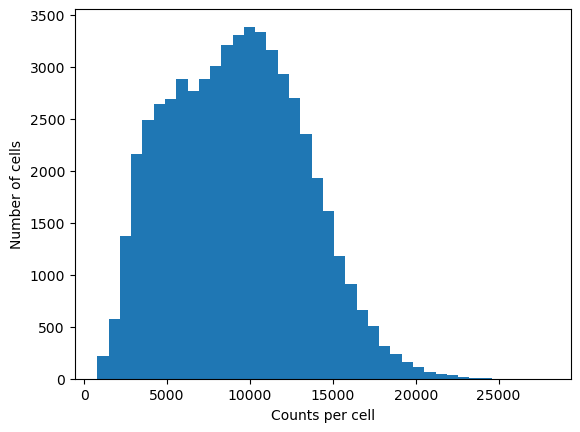

In [3]:
counts_per_cell = np.asarray(umi_counts_adata.X.sum(axis=1))
plt.hist(counts_per_cell, bins=40)
plt.xlabel("Counts per cell")
plt.ylabel("Number of cells")
plt.show()

Although the cells have been QCed (as described above and in further detail in the corresponding literature), the count matrix contains numerous genes with zero expression.

In [4]:
counts_per_gene = np.asarray(umi_counts_adata.X.sum(axis=0)).squeeze()
print(f"{np.count_nonzero(counts_per_gene == 0):,} genes have zero count")

5,250 genes have zero count


For the Hagai *et al.* (2018) study these genes may have been retained for cross-species interest. For this analysis, they may be removed.

In [5]:
scanpy.pp.filter_genes(umi_counts_adata, min_counts=1)

print(f"The UMI count matrix now contains {umi_counts_adata.n_vars:,} genes")

The UMI count matrix now contains 16,798 genes


A mean-variance scatter plot of expression for all genes shows a general pattern of overdispersion when relative to a Poisson distribution (the black line).

In [6]:
def plot_mean_var_scatter(counts, scale="log", title=""):
    x, y = genes_mean, genes_var = sparsefuncs.mean_variance_axis(counts, axis=0)
    plt.scatter(x, y, color="orange")

    sorted_idx = x.argsort()
    mv_x = x[sorted_idx]

    mv_y_poisson = mv_x
    plt.plot(mv_x, mv_y_poisson, "k:")

    mv_y_data = y[sorted_idx]
    r2 = r2_score(mv_y_data, mv_y_poisson)

    plt.xscale(scale)
    plt.yscale(scale)

    plt.title(title)
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.show()

    display(Latex(f"$R^2$ of mean=variance Poisson fit: {r2:.2f}"))

In [7]:
@widgets.interact(log_scale=True)
def plot_umi_mean_var(log_scale):
    plot_mean_var_scatter(umi_counts_adata.X, scale="log" if log_scale else "linear")

interactive(children=(Checkbox(value=True, description='log_scale'), Output()), _dom_classes=('widget-interact…

Similar plots are shown below for a variety of global count scaling options including counts per million (CPM), counts per thousand (CPT) and scaling by the (reciprocal of the) median total count of all cells.

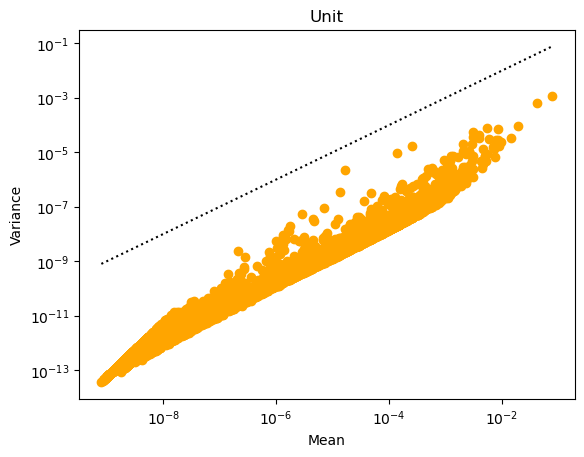

<IPython.core.display.Latex object>

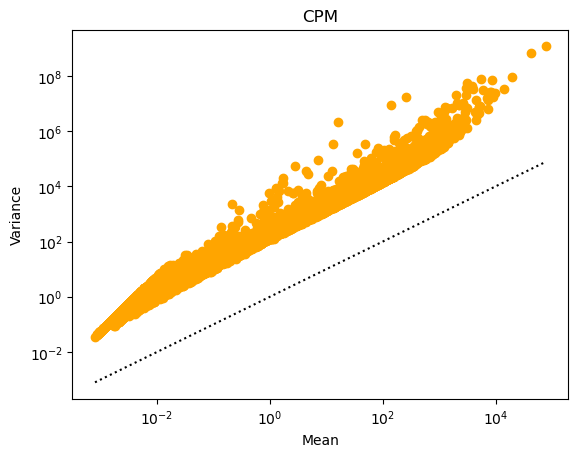

<IPython.core.display.Latex object>

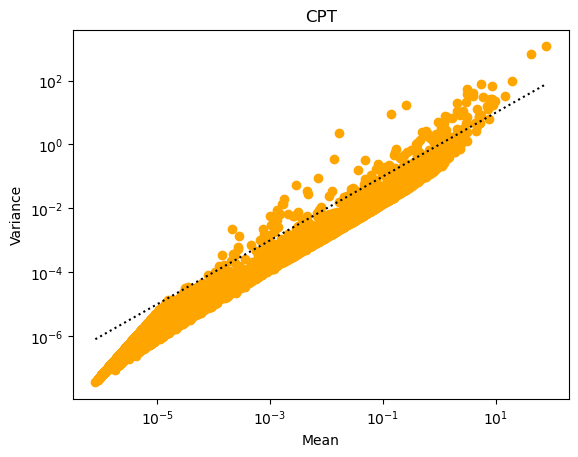

<IPython.core.display.Latex object>

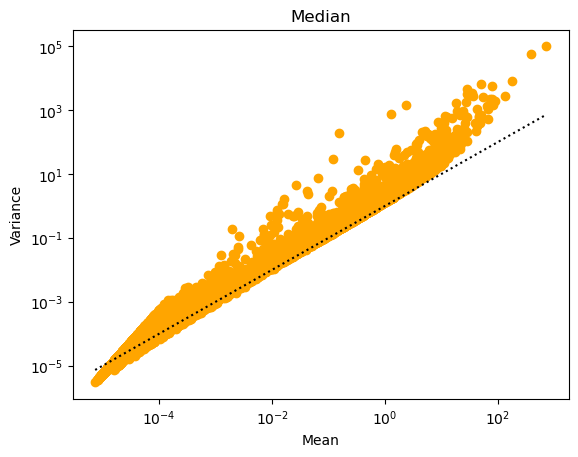

<IPython.core.display.Latex object>

In [8]:
counts_map = {
    "UMI": umi_counts_adata,
    "Unit": create_normalised_adata(umi_counts_adata, 1),
    "CPM": create_normalised_adata(umi_counts_adata, 1e6),
    "CPT": create_normalised_adata(umi_counts_adata, 1e3),
    "Median": create_normalised_adata(umi_counts_adata, None),
}

for name, counts_adata in counts_map.items():
    if name == "UMI": continue
    plot_mean_var_scatter(counts_adata.X, title=name)

Taking further inspiration from a [post by Valentine Svensson](http://www.nxn.se/valent/2018/1/30/count-depth-variation-makes-poisson-scrna-seq-data-negative-binomial), the effacts of scaling upon dropout probabilities can be visualised.

In [9]:
def plot_dropout_probability(counts, axis=0, title=""):
    x, _ = sparsefuncs.mean_variance_axis(counts, axis=axis)

    n_cells = counts.shape[axis]
    n_zeros = n_cells - counts.getnnz(axis=axis)
    y = n_zeros / n_cells

    x_range = x.min(), x.max()
    x2 = np.geomspace(*x_range)
    y2 = np.exp(-x2)
    
    plt.scatter(x, y, color="orange")
    plt.plot(x2, y2, "k:")

    plt.xscale("log")

    plt.title(title)
    plt.xlabel("Mean")
    plt.ylabel("Dropout probability")
    plt.show()

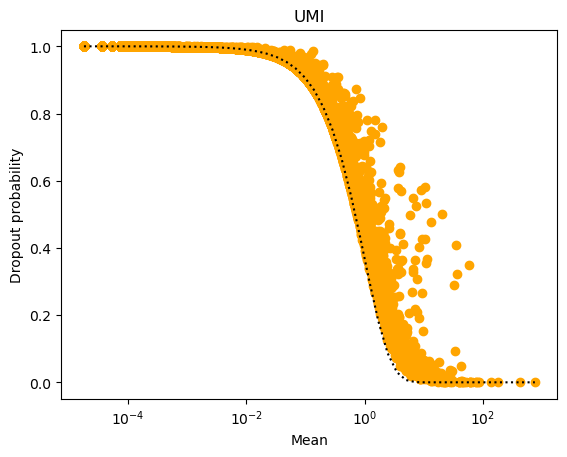

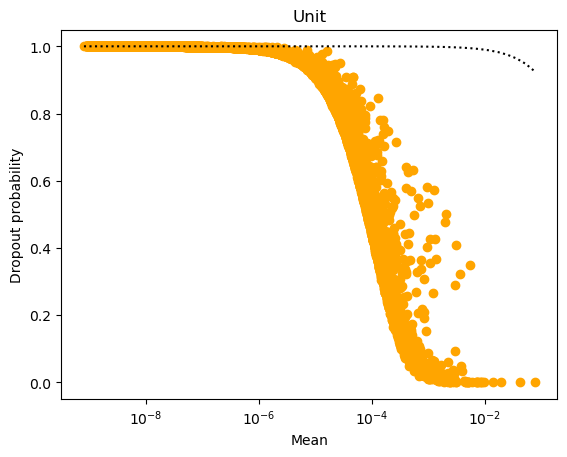

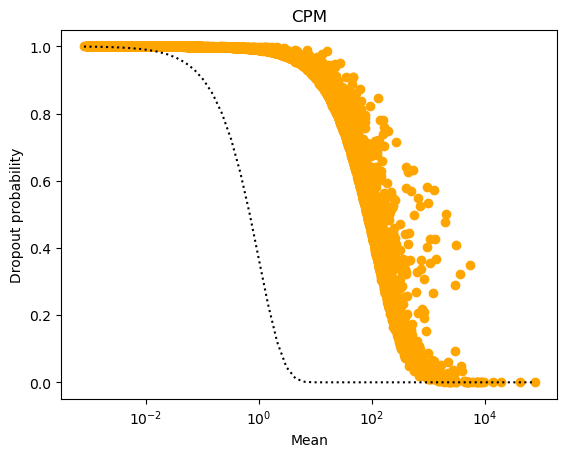

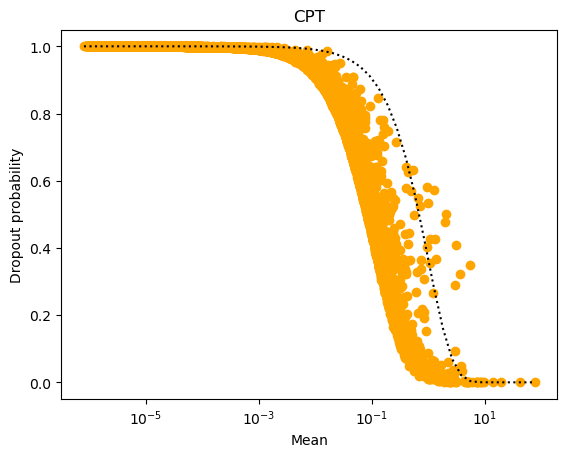

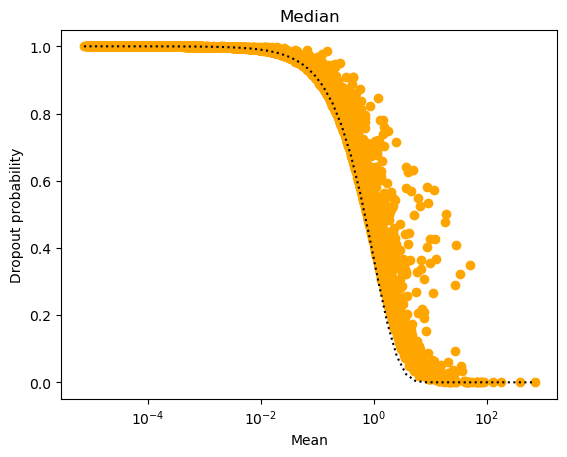

In [10]:
for name, counts_adata in counts_map.items():
    plot_dropout_probability(counts_adata.X, title=name)